**Light задание**
1. Возьмите любые 10 изображений. Напишите свой класс для создания Dataset, в который на вход будут подаваться: путь с файлами, listID, labels. При этом изображения должны быть на выходе (xTrain) ч/б, перевернутые, урезанные до размера (32х32) и вытянутые в вектор.
2. Напишите архитектуру сетки, которая будет обрабатывать данные из пункта 1.
3. Напишите процесс обучения для такой архитектуры, используйте loss, criterion и optimizer не из занятия.


In [ ]:
import numpy as np # импортируем Numpy
import scipy # импортируем Scipy

# библиотеки для использования PyTopch
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

# для оценки времени
import datetime, os
import time

# для работы с картинкой и графиками
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# подключаем Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# убеждаемся, что используем видеокарту
!nvidia-smi

Sat Nov 14 13:20:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# для работы с датасетом
class CustomDataset(data.Dataset):
  def __init__(self, listID, labels, path, transforms=None):
    self.listID = listID
    print(self.listID)
    self.labels = labels
    print(self.labels)
    self.transforms = transforms
    self.path = path

  def __getitem__(self, index):
    ID = self.listID[index]
    image = cv2.imread(path + ID)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if self.transforms:
      image = self.transforms(image)
    trainX = image
    trainY = self.labels[index]

    return trainX, trainY

  def __len__(self):
    return len(self.listID)

In [ ]:
# преобразуем датасет, как необходимо по заданию
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Grayscale(),
                                transforms.RandomHorizontalFlip(p=1.0),
                                transforms.Resize((32,32)),
                                transforms.Lambda(lambda x: torch.flatten(x))

])

Нарисовал 10 картинок: 5 крестиков и 5 галочек.

In [ ]:
# загружаем картинки для датасета, создаём метки
path = '/content/drive/My Drive/lesson25/' 
listID = os.listdir(path)
labels = [0,1,1,0,0,0,0,1,1,1] # 0 - крестик, 1 - галочка
print(listID)

['1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png']


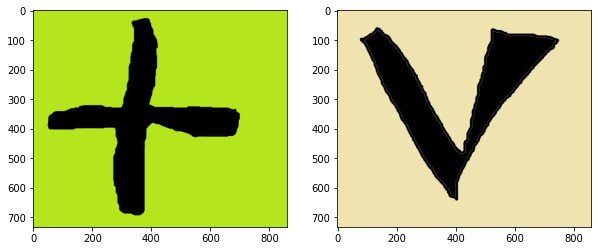

In [ ]:
# Посмотрим на примеры изображений
img1 = Image.open(path+listID[0])
img2 = Image.open(path+listID[1])

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(img1)
ax[1].imshow(img2)
plt.show()

In [ ]:
# Информация о датасете
customData = CustomDataset(listID[2:], labels[2:], path, transform)
len(customData)

['3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png']
[1, 0, 0, 0, 0, 1, 1, 1]


8

In [ ]:
# Создадим dataloader
trainLoader = torch.utils.data.DataLoader(dataset=customData,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=4)

In [ ]:
# Посмотрим на пример генерации
dataiter = iter(trainLoader)
images = dataiter.next()
print(images[0].shape, images[1].shape)

torch.Size([4, 1024]) torch.Size([4])


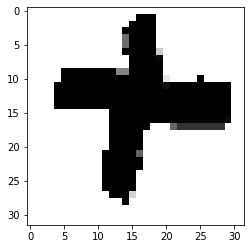

In [ ]:
# И на преобразование изображения
test_image = images[0][0].numpy().reshape(32,32)
plt.imshow(test_image, plt.cm.gray)
plt.show()

In [ ]:
# объявляем константы
input_size = 1024
num_classes = 1
epochs = 20
learning_rate = 1e-3
hidden_size = 400
class_names = ['cross', 'ok']

In [ ]:
# класс модели
class Classification(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    self.layer1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(hidden_size, num_classes)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    out = self.layer1(x)
    out = self.relu(out)
    out = self.layer2(out)
    out = self.sigmoid(out)
    return out

In [ ]:
# создаём модель
model = Classification(input_size, hidden_size, num_classes)

model(images[0])

tensor([[0.4925],
        [0.5006],
        [0.4921],
        [0.5066]], grad_fn=<SigmoidBackward>)

In [ ]:
# компилируем модель
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
model.train()

Classification(
  (layer1): Linear(in_features=1024, out_features=400, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=400, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# если есть видеокарта, работаем с моделью на ней
cuda = torch.cuda.is_available()
if cuda:
  model = model.cuda()

Epoch: 1/20, loss: 0.1724882572889328
Epoch: 2/20, loss: 0.17326202988624573
Epoch: 3/20, loss: 0.09523004293441772
Epoch: 4/20, loss: 0.09198232740163803
Epoch: 5/20, loss: 0.08381496369838715
Epoch: 6/20, loss: 0.05879868194460869
Epoch: 7/20, loss: 0.043901532888412476
Epoch: 8/20, loss: 0.040747664868831635
Epoch: 9/20, loss: 0.03604231774806976
Epoch: 10/20, loss: 0.028824614360928535
Epoch: 11/20, loss: 0.02217693254351616
Epoch: 12/20, loss: 0.019135354086756706
Epoch: 13/20, loss: 0.017710944637656212
Epoch: 14/20, loss: 0.01607638970017433
Epoch: 15/20, loss: 0.013468087650835514
Epoch: 16/20, loss: 0.011232404038310051
Epoch: 17/20, loss: 0.010078935883939266
Epoch: 18/20, loss: 0.008135306648910046
Epoch: 19/20, loss: 0.007461389992386103
Epoch: 20/20, loss: 0.00655026501044631


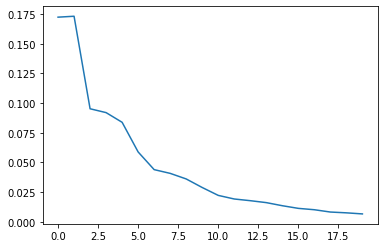

In [ ]:
# обучаем модель
for epoch in range(epochs):
  lossTot = 0

  for i, (images, labels) in enumerate(trainLoader):
    labels = labels.view(-1,1).type(torch.FloatTensor)
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()

    lossTot += loss.detach().data

    optimizer.step()

  losses.append(lossTot/len(customData))
  print(f'Epoch: {epoch+1}/{epochs}, loss: {losses[-1]}')

plt.plot(losses)
plt.show()

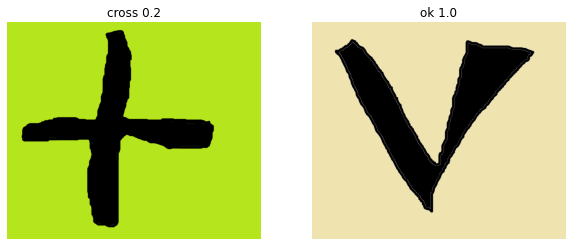

In [ ]:
# проверяем работу модели
model.eval()

fig, ax = plt.subplots(1,2, figsize=(10,5))

for i, id in enumerate(listID[:2]):
  test_image = cv2.cvtColor(cv2.imread(path + id), cv2.COLOR_BGR2RGB)
  test_image_for_predict = transform(test_image)
  test_image_for_predict = test_image_for_predict.cuda()
  prediction = model(test_image_for_predict).cpu().detach().numpy()[0]
  ax[i].imshow(test_image)
  ax[i].axis('off')
  ax[i].title.set_text(class_names[int(round(prediction))] + ' ' + str(round(prediction, 2)))

plt.show()